<a href="https://colab.research.google.com/github/AstridSerruto/Projects/blob/master/Predicting/Restaurant_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Restaurant Success prediction

Internet accessibility is increasing in different parts of the world over the years. E-commerce is a medium powered by the internet, where customers can access an online store to browse through, and place orders for products. 

##Business Problem

Zomato is an Online food ordering service, serving worldwide in which users can order food from the website or from mobile based applications. For this business problem, we are restricting only to the Bangalore region and Bangalore based restaurants. Dataset was  made available on Kaggle, March 2019. The basic idea of analyzing the Zomato dataset is to get a good idea about the factors affecting the different types of the restaurant in Bangalore. 

https://www.kaggle.com/datasets/absin7/zomato-bangalore-dataset

##Machine Learning Problem Formulation

The given problem can be solved either by binary classification problem (0 as failure or 1 as success), or Regression problem(for predicting scores) based on the given features.

The objective is to predict the success of a restaurant. Based on the prediction from the Model, a new investor can make the decision on whether to establish the restaurant or not.

##Performance Metric

We are solving this problem as a Binary classification task, where we need to predict whether a new restaurant will be successful or not. We will use metrics such as F1score/AUC .

##Exploratory Data Analysis

What can the data tell us?

    Which franchise has the highest number of Restaurants?
    How many Restaurants are accepting online orders?
    Which location has the highest number of Restaurants?
  

In [44]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 
!pip install category_encoders
!pip install pycaret
!pip install markupsafe==2.0.1
!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
#Install imports

import lightgbm as lgb
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import sys
import xgboost as xgb

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,f1_score,precision_score,recall_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion,make_pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, StandardScaler,MinMaxScaler
from pandas_profiling.utils.cache import cache_file
from category_encoders import TargetEncoder
#from category_encoders import vLeaveOneOutEncoder
from category_encoders import WOEEncoder, BinaryEncoder
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [46]:
import re
re.findall(r'[\w]+@[\w]+.\w{2,}','se.a@gds.ey.com')

['a@gds.ey']

In [47]:
#Import data
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/My Drive/Predictions/Prediction_1/zomato.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

The dataset has 51717 rows and 17 columns.
We have missing values in 7 columns. We will calculate the percentage of missing values.

In [50]:
#Renaming some of the columns
df = df.rename(columns={'rate':'rating','listed_in(type)':'type',
                                  'listed_in(city)':'city'})

In [51]:
#Calculating missing percentage
percent_missing = df.isnull().sum() * 100 / len(df)

In [52]:
percent_missing

url                             0.000000
address                         0.000000
name                            0.000000
online_order                    0.000000
book_table                      0.000000
rating                         15.033741
votes                           0.000000
phone                           2.335789
location                        0.040606
rest_type                       0.438927
dish_liked                     54.291626
cuisines                        0.087012
approx_cost(for two people)     0.669026
reviews_list                    0.000000
menu_item                       0.000000
type                            0.000000
city                            0.000000
dtype: float64

Plot shows column dish_like has more than 50% missing values and rating contains 15%. We will do some more analysis on the rating column, since our final goal is to predict the success of a restaurant based on threshold value of rating column.

In [53]:
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

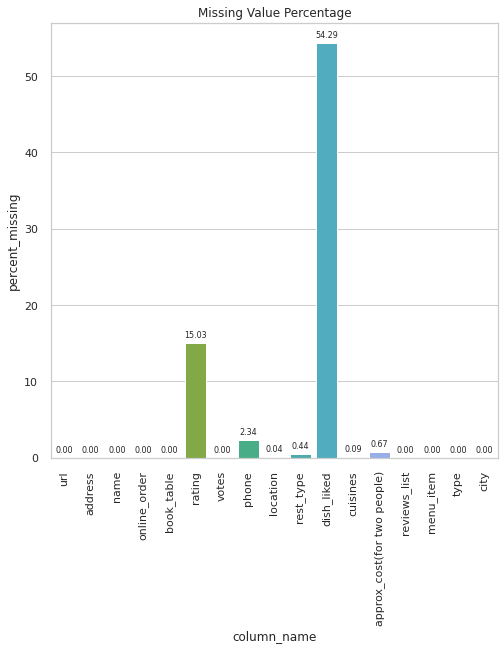

In [54]:
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid", color_codes=True)
plots = sns.barplot(x = 'column_name', y = 'percent_missing', data=missing_value_df)
# Iterrating over the bars one-by-one
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
plt.title("Missing Value Percentage")
plt.xticks(rotation = 90)
plt.show()

Plot shows column dish_like has more than 50% missing values and rating contains close to 15%. We will do some more analysis on the rating column, since our final goal is to predict the rating.

In [55]:
#Extracting only the rating part
df['rating'] = df['rating'].apply(lambda x: str(x).split('/')[0])
print(df['rating'].unique())
print(df['approx_cost(for two people)'].unique())

['4.1' '3.8' '3.7' '3.6' '4.6' '4.0' '4.2' '3.9' '3.1' '3.0' '3.2' '3.3'
 '2.8' '4.4' '4.3' 'NEW' '2.9' '3.5' 'nan' '2.6' '3.8 ' '3.4' '4.5' '2.5'
 '2.7' '4.7' '2.4' '2.2' '2.3' '3.4 ' '-' '3.6 ' '4.8' '3.9 ' '4.2 '
 '4.0 ' '4.1 ' '3.7 ' '3.1 ' '2.9 ' '3.3 ' '2.8 ' '3.5 ' '2.7 ' '2.5 '
 '3.2 ' '2.6 ' '4.5 ' '4.3 ' '4.4 ' '4.9' '2.1' '2.0' '1.8' '4.6 ' '4.9 '
 '3.0 ' '4.8 ' '2.3 ' '4.7 ' '2.4 ' '2.1 ' '2.2 ' '2.0 ' '1.8 ']
['800' '300' '600' '700' '550' '500' '450' '650' '400' '900' '200' '750'
 '150' '850' '100' '1,200' '350' '250' '950' '1,000' '1,500' '1,300' '199'
 '80' '1,100' '160' '1,600' '230' '130' '50' '190' '1,700' nan '1,400'
 '180' '1,350' '2,200' '2,000' '1,800' '1,900' '330' '2,500' '2,100'
 '3,000' '2,800' '3,400' '40' '1,250' '3,500' '4,000' '2,400' '2,600'
 '120' '1,450' '469' '70' '3,200' '60' '560' '240' '360' '6,000' '1,050'
 '2,300' '4,100' '5,000' '3,700' '1,650' '2,700' '4,500' '140']


‘rating’ column contains values such as ‘NEW’, which is for new restaurants and ‘-’, for those restaurants which are not rated. We will remove these records along with nan. ‘approx_cost(for two people)’ column contains values with comma, hence this is considered as object, we will convert it back to float. We will also delete Unnecessary Columns ‘phone’, ‘url’.

##Data Preprocessing and Cleaning

In [56]:
#Data clean up
df = df[~df['rating'].isin(['NEW','-'])].drop(['url','phone','dish_liked'],axis=1).dropna() 
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].apply(lambda x: str(x).replace(',',''))
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].astype(float)
df['rating'] = df['rating'].astype(float)
df['cuisines'] = df['cuisines'].apply(lambda x: ','.join(sorted(x.split(','))))
#df['dish_liked'] = df['dish_liked'].apply(lambda x: ','.join(sorted(x.split(','))))
df['target'] = np.where(df.rating>=df.rating.mean(), "Sucess", "Failure")
#Check for dupliacte records and delete if any
df.duplicated().sum()#35 records are duplicated
df.drop_duplicates(inplace=True)

##Exploratory Data Analysis

In [57]:
df.name.nunique()

8385

In [58]:
print(df.name.unique())
df.loc[df['name'] == 'Jalsa', ].sort_values(by = 'location', axis = 0)

['Jalsa' 'Spice Elephant' 'San Churro Cafe' ... 'Nawabs Empire'
 'SeeYa Restaurant'
 'Plunge - Sheraton Grand Bengaluru Whitefield Hotel &...']


,address,name,online_order,book_table,rating,votes,location,rest_type,cuisines,approx_cost(for two people),reviews_list,menu_item,type,city,target
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"Chinese, Mughlai,North Indian",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari,Sucess
456,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"Chinese, Mughlai,North Indian",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Delivery,Banashankari,Sucess
559,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"Chinese, Mughlai,North Indian",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Dine-out,Banashankari,Sucess
2488,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"Chinese, Mughlai,North Indian",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Basavanagudi,Sucess
2966,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"Chinese, Mughlai,North Indian",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Delivery,Basavanagudi,Sucess
3462,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,804,Banashankari,Casual Dining,"Chinese, Mughlai,North Indian",800.0,"[('Rated 4.0', 'RATED\n Super ambience\nGreat...",[],Dine-out,Basavanagudi,Sucess
19401,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,783,Banashankari,Casual Dining,"Chinese, Mughlai,North Indian",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Jayanagar,Sucess
20399,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,783,Banashankari,Casual Dining,"Chinese, Mughlai,North Indian",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Delivery,Jayanagar,Sucess
21302,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,783,Banashankari,Casual Dining,"Chinese, Mughlai,North Indian",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Dine-out,Jayanagar,Sucess
7607,"25/7, Doddannakundi, Outer Ring Road, Mahadeva...",Jalsa,Yes,Yes,4.2,2173,Marathahalli,Casual Dining,"Mughlai,North Indian",1500.0,"[('Rated 4.0', 'RATED\n A pretty decent place...",[],Delivery,Brookefield,Sucess


In [59]:
df.loc[df['name'] == 'nu.tree', ].sort_values(by = 'location', axis=0)

,address,name,online_order,book_table,rating,votes,location,rest_type,cuisines,approx_cost(for two people),reviews_list,menu_item,type,city,target
13903,"47/7 First floor, DoddaThogur Road, Near Velan...",nu.tree,No,No,NaN,0,Electronic City,Casual Dining,"Beverages, Healthy Food,North Indian",400.0,[],[],Delivery,Electronic City,Failure
3812,"36 Aarush, Sri Balaji Layout, Ambulipura, Sarj...",nu.tree,Yes,No,4.4,278,Sarjapur Road,Delivery,"Beverages, Healthy Food,North Indian",400.0,"[('Rated 4.0', 'RATED\n I ordered their veg m...",[],Delivery,Bellandur,Sucess
16258,"36 Aarush, Sri Balaji Layout, Ambulipura, Sarj...",nu.tree,Yes,No,4.4,280,Sarjapur Road,Delivery,"Beverages, Healthy Food,North Indian",400.0,"[('Rated 4.0', 'RATED\n One of those budget r...",[],Delivery,HSR,Sucess
48901,"36 Aarush, Sri Balaji Layout, Ambulipura, Sarj...",nu.tree,Yes,No,4.3,300,Sarjapur Road,Delivery,"Beverages, Healthy Food,North Indian",400.0,"[('Rated 3.0', 'RATED\n Decreasing my rating ...",[],Delivery,Sarjapur Road,Sucess
7110,"Ground Floor-Lobby Area, Brigade IRV Centre, N...",nu.tree,Yes,No,4.3,170,Whitefield,"Quick Bites, Beverage Shop","Beverages, Healthy Food,North Indian",400.0,"[('Rated 5.0', 'RATED\n This is second time I...","['Fruit Porridge Meal', 'Dum Aloo and Chapathi...",Delivery,Brookefield,Sucess
40984,"Ground Floor-Lobby Area, Brigade IRV Centre, N...",nu.tree,Yes,No,4.3,178,Whitefield,"Quick Bites, Beverage Shop","Beverages, Healthy Food,North Indian",400.0,"[('Rated 5.0', 'RATED\n This is second time I...","['Fruit Porridge Meal', 'Dum Aloo and Chapathi...",Delivery,Marathahalli,Sucess
50269,"Ground Floor-Lobby Area, Brigade IRV Centre, N...",nu.tree,Yes,No,4.3,185,Whitefield,"Quick Bites, Beverage Shop","Beverages, Healthy Food,North Indian",400.0,"[('Rated 5.0', 'RATED\n This is second time I...",[],Delivery,Whitefield,Sucess
51376,"12th Floor, Gamma Building, Sigma Soft Tech Pa...",nu.tree,Yes,No,4.2,52,Whitefield,Quick Bites,"Beverages, Healthy Food,North Indian",400.0,"[('Rated 5.0', 'RATED\n Palak is my favourite...",[],Dine-out,Whitefield,Sucess


Analysis shows we a have total of 8385 restaurants listed in Zomato Bangalore. Restaurant ‘nu.tree’ is situated in 3 locations.
Every outlet of this restaurant for a specific location is having a separate entry based on the features restaurant have such as Dine-out, Buffet & Delivery.

We can have multiple records for the same restaurant in the dataset.


##Univarate Analysis

We will start with Univarate analysis on columns such as name, 'online_order', 'book_table', 'rating', 'votes', 'rest_type', 'cuisines', and 'approx_cost(for two people)'.


In [60]:
df.dropna(inplace=True)
class_dist = pd.DataFrame(df['target'].value_counts(normalize=True))
class_dist['target'] = class_dist['target']*100

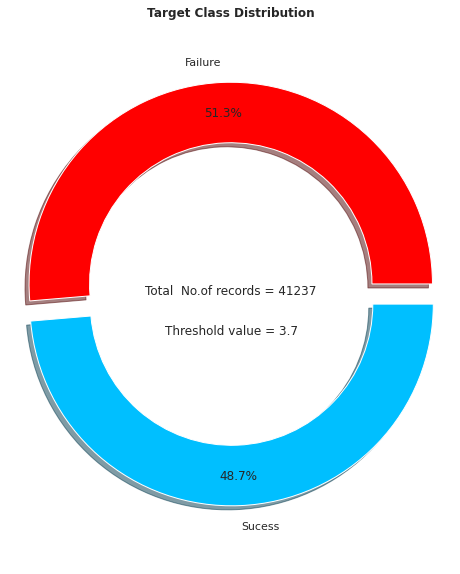

In [61]:
colors = ['red','DeepSkyBlue']
# explosion
explode = (0.05, 0.05)
  
fig1, ax1 = plt.subplots()
# Pie Chart

ax1.pie(class_dist['target'].values, colors=colors, labels=class_dist.index,
        autopct='%1.1f%%', pctdistance=0.85, wedgeprops=dict(width=0.3),shadow=True,
        explode=explode)
sumstr = 'Total  No.of records = '+str(df.shape[0])
fig1.subplots_adjust(top=1.5) 
# String on the donut center
ax1.text(0., 0., sumstr, horizontalalignment='center')
ax1.text(0., -0.2, 'Threshold value = '+str(round(df.rating.mean(),2)), horizontalalignment='center')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Target Class Distribution',fontweight='bold')
plt.show()

Our dataset is well balanced. A close to 50-50 class distribution is observed across 401237 records. In order to classify the sucess/failure of a restuarant, threshold value of 3.7 is used.

Create Dataframe which contains Top 10 Cuisines, Restaurants, Location, Restuarant types


In [62]:
df['cuisines'] = df['cuisines'].apply(lambda x: ','.join(sorted(x.split(','))))

In [63]:
top_cuisine = df['cuisines'].value_counts()[:10].rename_axis('cuisines').reset_index(name='counts')
top_rest = df['name'].value_counts()[:10].rename_axis('name').reset_index(name='counts')
top_loc = df['location'].value_counts()[:10].rename_axis('location').reset_index(name='counts')
top_types = df['rest_type'].value_counts()[:10].rename_axis('rest_type').reset_index(name='counts')

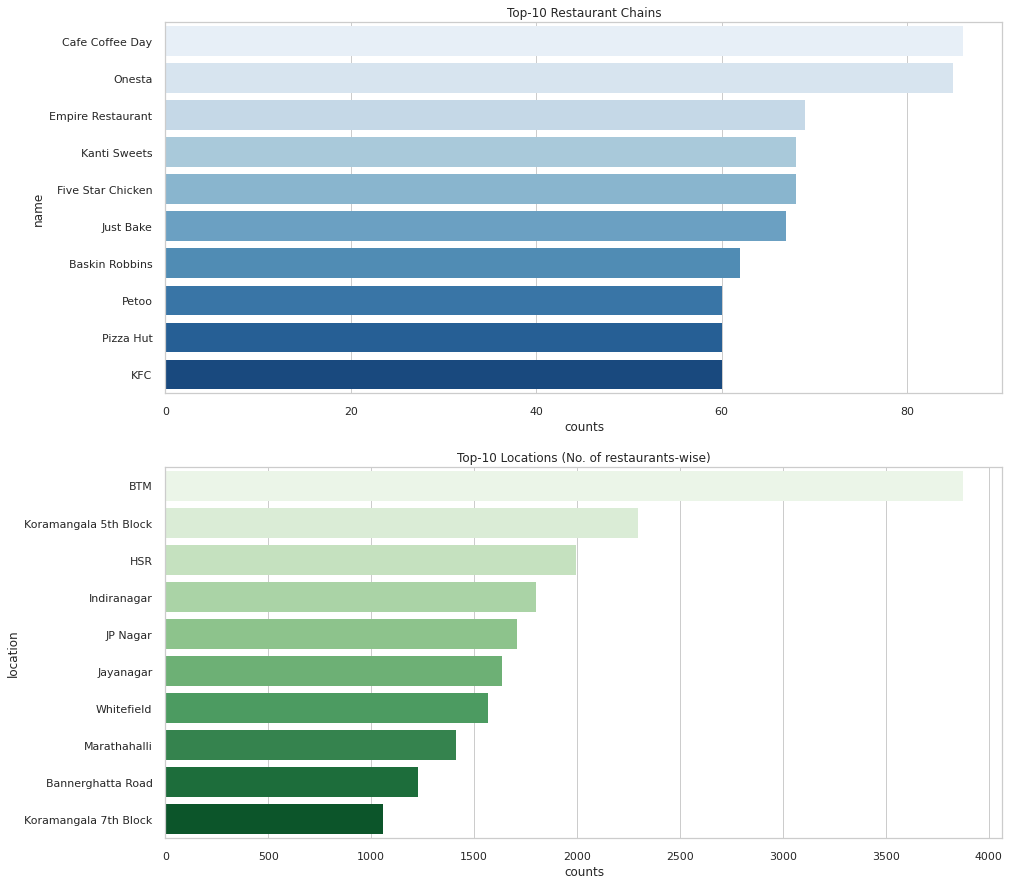

<Figure size 576x576 with 0 Axes>

In [64]:
fig, axes = plt.subplots(2, 1,figsize=(15,15))
plt.figure(figsize=(8, 8))
axes = axes.flatten()
ax1 = sns.barplot(x='counts', y='name', data=top_rest,  orient='h', ax=axes[0], palette='Blues', lw=0)
#ax2 = sns.barplot(x='counts', y='cuisines', data=top_cuisine,  orient='h', ax=axes[1], palette='OrRd', lw=0)
ax3 = sns.barplot(x='counts', y='location', data=top_loc,  orient='h', ax=axes[1], palette='Greens', lw=0)
ax1.title.set_text('Top-10 Restaurant Chains')
#ax2.title.set_text('Top-10 Cuisines (No. of restaurants-wise)')
ax3.title.set_text('Top-10 Locations (No. of restaurants-wise)')
#ax4.title.set_text('Fourth Plot')

In the above graphs, we can see top-10 popular restaurants and top 10 locations in Bangalore based on the number of restaurants.

We can see that Cafe Coffee Day is the most popular restaurant chain in Bangalore. Bangalore is a big IT hub, with many medium-to-small companies and educational institutes. Data shows BTM, Koramangala and HSR locations have the largest number of restaurants.

Now lets check the percentage composition of no of restaurants in these locations.

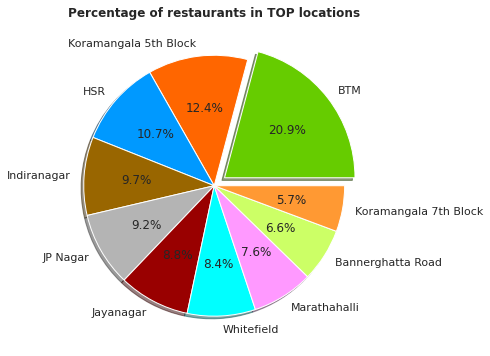

In [65]:
plt.figure(figsize = (12,6))
colors = ("#66CC00","#FF6600", "#0099FF", "#996600",
          "#b4b4b4", "#990000", "#00FFFF","#FF99FF","#CCFF66","#FF9933")
explode = (0.1, 0, 0, 0,0,0,0,0,0,0)  # explode 1st slice
plt.pie(top_loc['counts'], explode=explode, labels=top_loc['location'], colors=colors,autopct='%1.1f%%', shadow=True,)
plt.title("Percentage of restaurants in TOP locations", weight = 'bold')
  
# show plot
plt.show()

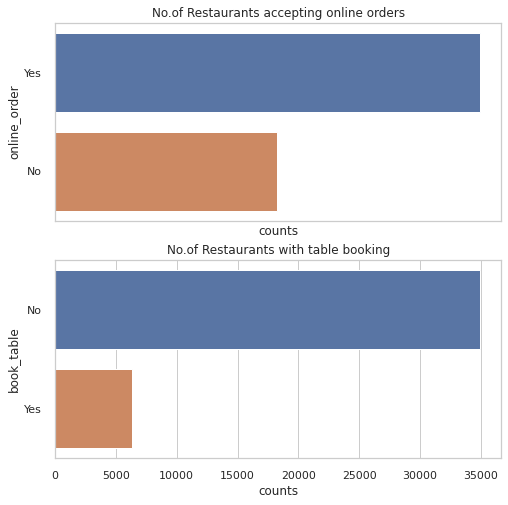

<Figure size 576x576 with 0 Axes>

In [66]:
online_df = df['online_order'].value_counts().rename_axis('online_order').reset_index(name='counts')
book_df = df['book_table'].value_counts().rename_axis('book_table').reset_index(name='counts')
fig, axes = plt.subplots(2, 1,figsize=(8,8))
plt.figure(figsize=(8, 8))
axes = axes.flatten()
ax1 = sns.barplot(x='counts', y='online_order', data=online_df,  orient='h', ax=axes[0])
ax2 = sns.barplot(x='counts', y='book_table', data=book_df,  orient='h', ax=axes[1])
ax1.title.set_text('No.of Restaurants accepting online orders')
ax1.set_xticks([])
ax2.title.set_text('No.of Restaurants with table booking')


We see that a majority of restaurants(35,000+) have online ordering. But only over 5000 have table booking.

##Multivarate Analysis

Multivariate analysis deals with the statistical analysis of data collected on more than one dependent variable.

Does online ordering and booking table facility have any impact on the success of a restaurant?


Text(0.5, 0.98, 'Target vs Book table vs Online Order')

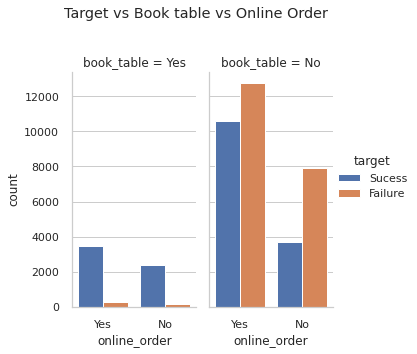

In [67]:
g = sns.catplot(x="online_order",col='book_table',
                data=df, saturation=.9,hue='target',
                kind="count", ci=None, aspect=.5)
g.fig.subplots_adjust(top=0.8) 
g.fig.suptitle("Target vs Book table vs Online Order")

Restaurants with table booking option tend to be more sucessful even if the restaurant doesnt provide online ordering. However, the sucess rate for the restaurants with no table booking option and online ordering service was observed to be low. Even if restauarnst provide online ordering service, success is not guranteed.


Text(0.5, 0.98, 'approx_cost vs Book table vs Online Order')

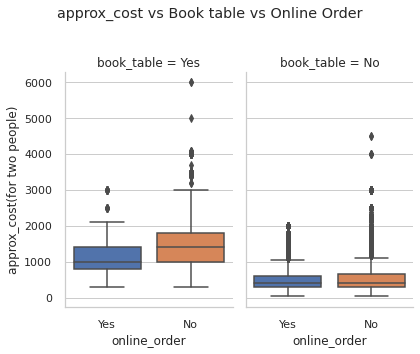

In [68]:
g = sns.catplot(x="online_order", y="approx_cost(for two people)",col='book_table',
                data=df, saturation=.9,
                kind="box", ci=None, aspect=.6)
g.fig.subplots_adjust(top=0.8) 
g.fig.suptitle("approx_cost vs Book table vs Online Order")



Approximate Cost of the food for two persons is higher for the restaurants with table booking option and with/without online orders.

Restaurants with table booking, do not accept orders online have higher food cost per 2 persons.


Text(0.5, 0.98, 'Target vs Book table vs Online Order')

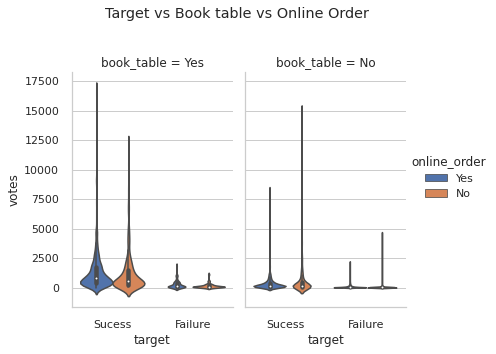

In [69]:
g = sns.catplot(x="target",y="votes",col='book_table',
                data=df, saturation=.9,hue='online_order',
                kind="violin", ci=None, aspect=.6)
g.fig.subplots_adjust(top=0.8) 
g.fig.suptitle("Target vs Book table vs Online Order")

Number of votes will increase as more customers visit the restaurant or the online site. Above plot shows as the number of votes increase, the restaurants success increases.

Restaurants with table booking option and online order option have the highest vote and have the best possibility of Success.

But Table booking and online ordering does not always result in success.


In [70]:
sucess_rate_loc = df[df['location'].isin(top_loc.location)]\
        .groupby(['location','target']).size()\
        .reset_index(name="count")
sucess_rate_loc['perc'] = sucess_rate_loc.groupby('location')['count'].apply(lambda x: x*100/x.sum())


Now lets add approx. cost column to the analysis. Approx. Cost of the food for two persons is higher for the restaurants with table booking option and with/without online orders.

Restaurants with table booking facility, do not accept orders online have higher food cost for two persons.

Q) Finding Top locations success rate for the restaurants and how it relates to no. of people voted .

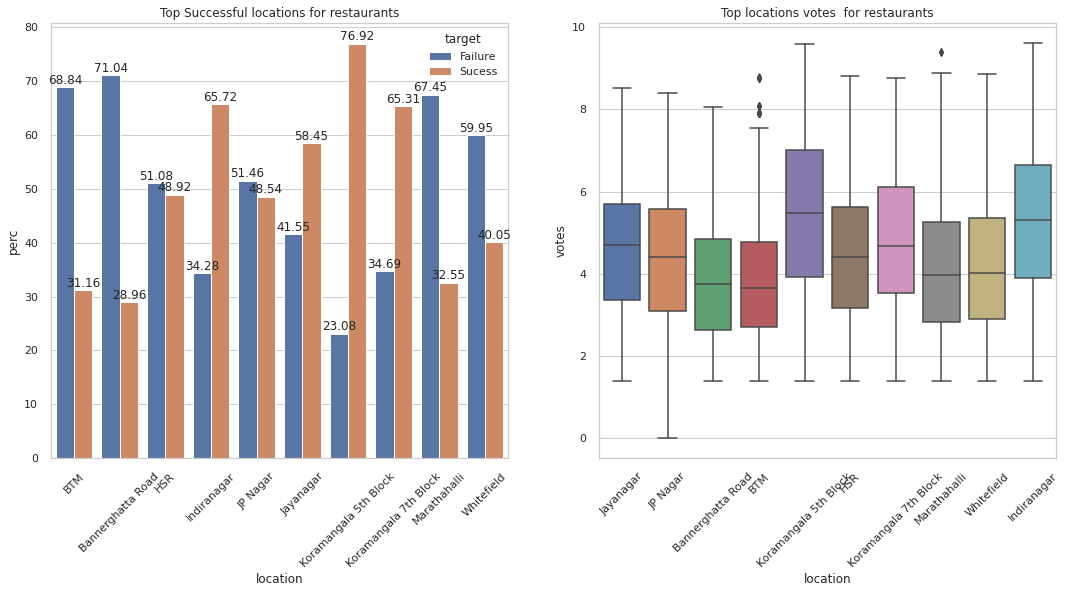

In [71]:
fig, axes = plt.subplots(1, 2,figsize=(18,8))
axes = axes.flatten()
#Subset of the data based on top 10 loactions based on retaurant count
ax2 = sns.barplot(x = 'location', y = 'perc',hue='target', ax=axes[0], data = sucess_rate_loc)
# Scaling the vote column by taking log(votes) to plot single plot and make inferences
ax3 = sns.boxplot(x = 'location', y = np.log(df['votes']), ax=axes[1], data = df[df['location'].isin(top_loc.location.values)])
for bar in ax2.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 7)
  # ha and va stand for the horizontal and vertical alignment
    ax2.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 7),
                   textcoords='offset points')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
# /plt.xlabel('Locations')
# plt.ylabel('rating')
ax2.title.set_text('Top Successful locations for restaurants')
ax3.title.set_text('Top locations votes  for restaurants')

Koramangala is one of the most voted locations, and a success rate of close to 77%. The Bannerghatta location has the highest failure rate and receives the least votes.

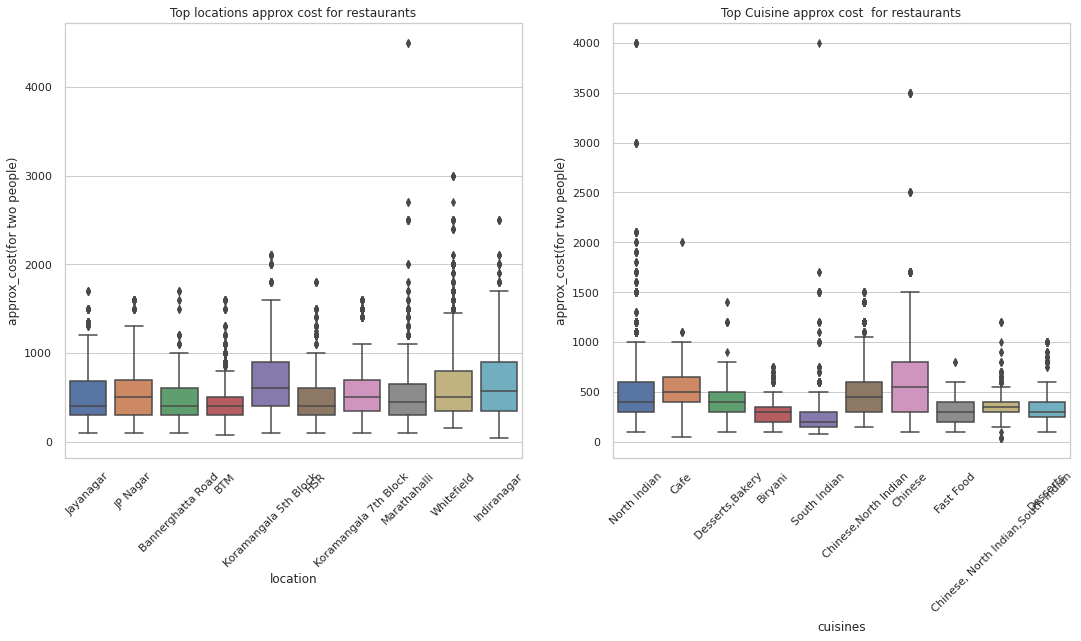

In [72]:
fig, axes = plt.subplots(1, 2,figsize=(18,8))
axes = axes.flatten()
#Subset of the data based on top 10 loactions based on retaurant count
ax2 = sns.boxplot(x = 'location', y = 'approx_cost(for two people)', ax=axes[0], data = df[df['location'].isin(top_loc.location.values)])
ax3 = sns.boxplot(x = 'cuisines', y = 'approx_cost(for two people)', ax=axes[1], data = df[df['cuisines'].isin(top_cuisine.cuisines.values)])
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
# /plt.xlabel('Locations')
# plt.ylabel('rating')
ax2.title.set_text('Top locations approx cost for restaurants')
ax3.title.set_text('Top Cuisine approx cost  for restaurants')

Indiranagar is a cosmopolitan locality, and is one of the most expensive neighbourhoods in Bangalore, and has some of the high end restaurants in the city. Most of the budget friendly restauranats are located in the BTM locality.

Looking at the cuisines offered in restuarants, chineese is more expensive, and we can see few outliers across the data. Those are due to the few premeium restaurants like Alba - JW Marriott, Riwaz - The Ritz-Carlton,The Lantern Restaurant etc

##Percentage of Restaurants in TOP 10 Location which accepts online order and Table booking Option


In [73]:
location_online = df[df['location'].isin(top_loc.location.values)]\
             .groupby(['location', 'online_order'])['location'].count().reset_index(name="count")
location_online['perc'] = location_online.groupby('location')['count'].apply(lambda x: x*100/x.sum())

table_online  = df[df['location'].isin(top_loc.location.values)]\
             .groupby(['location', 'book_table'])['location'].count().reset_index(name="count")
table_online['perc'] = table_online.groupby('location')['count'].apply(lambda x: x*100/x.sum())

Text(0.5, 0.98, '% of Restaurants accepting online order in Top locations')

<Figure size 1080x576 with 0 Axes>

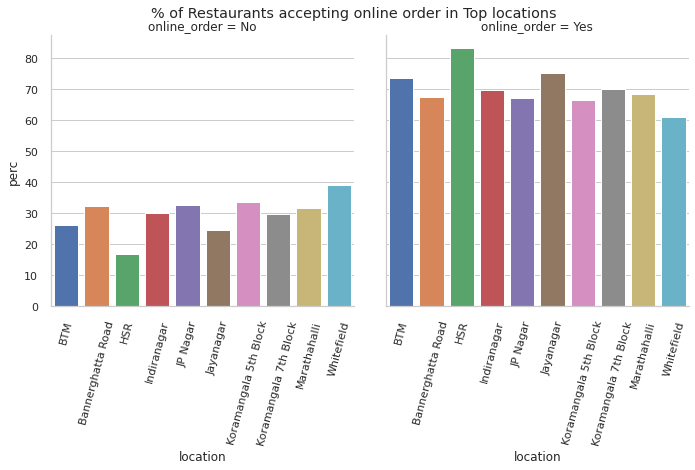

In [74]:
plt.figure(figsize=(15,8))
g = sns.catplot(x="location", y="perc",col='online_order',
                data=location_online, saturation=.9,
                kind="bar")
g.set_xticklabels(rotation=75)
g.fig.subplots_adjust(top=0.9) 
g.fig.suptitle("% of Restaurants accepting online order in Top locations")




More than 50% of restaurants in the Top locations accept online orders. HSR has the highest percentage of restaurants.

Whitefield has the most restaurants which do not accept online orders.


Text(0.5, 0.98, '% of Restaurants with table book option in Top locations')

<Figure size 1080x288 with 0 Axes>

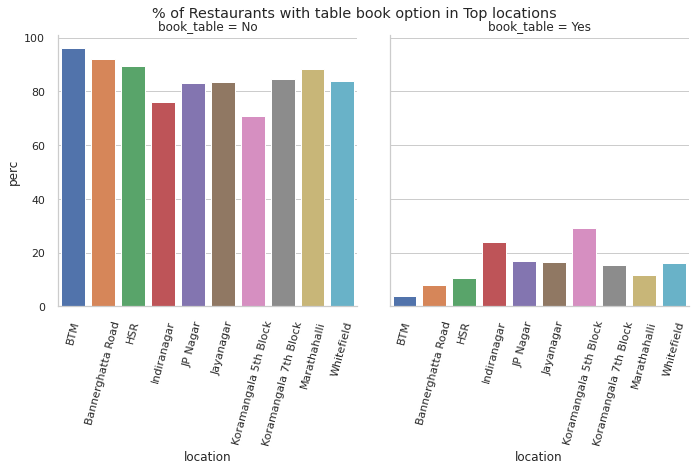

In [75]:
plt.figure(figsize=(15, 4))
g = sns.catplot(x="location", y="perc",col='book_table',
                data=table_online, saturation=.9,
                kind="bar")
g.set_xticklabels(rotation=75)
g.fig.subplots_adjust(top=0.9) 
g.fig.suptitle("% of Restaurants with table book option in Top locations")

95% of restaurants in the top-10 locations do not have an option for table reservations. Few restaurants in these locations provide booking options. Indiranagar, a place for premium restaurants, provides the highest option for table reservations.

In [76]:
top_cuisine

,cuisines,counts
0,North Indian,2107
1,"Chinese,North Indian",1949
2,South Indian,1231
3,Cafe,620
4,"Desserts,Bakery",613
5,"Chinese, North Indian,South Indian",607
6,Biryani,600
7,Desserts,545
8,Fast Food,513
9,Chinese,409


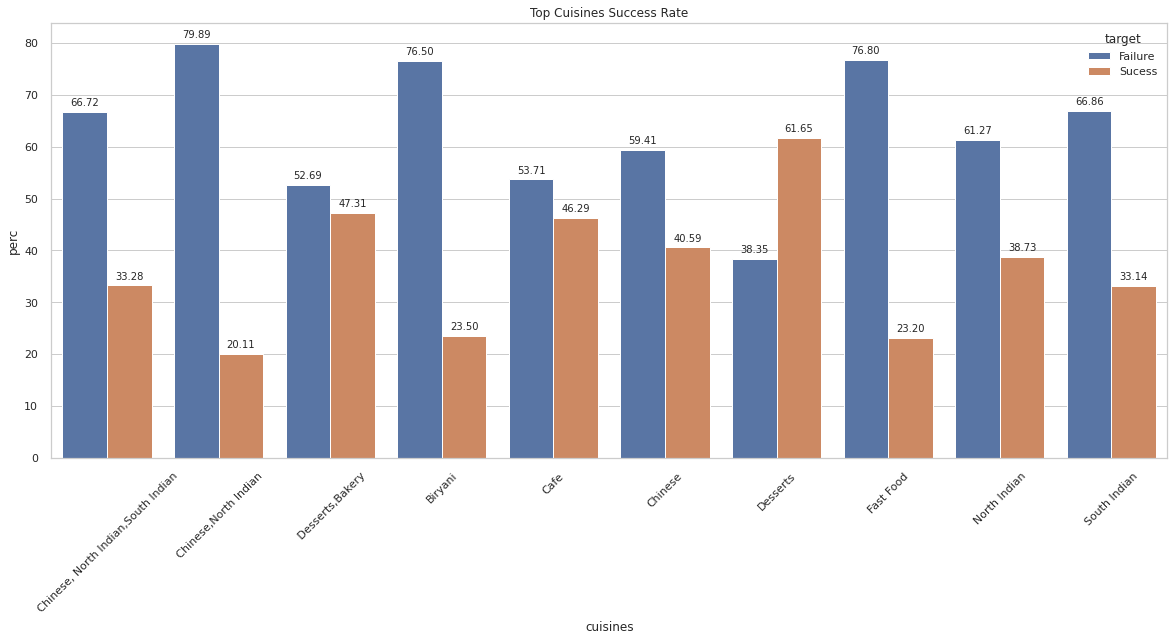

In [77]:
success_rate_cui = df[df['cuisines'].isin(top_cuisine.cuisines)]\
        .groupby(['cuisines','target']).size()\
        .reset_index(name="count")
success_rate_cui['perc'] = success_rate_cui.groupby('cuisines')['count'].apply(lambda x: x*100/x.sum())
plt.figure(figsize = (20,8))
ax2 = sns.barplot(x = 'cuisines',y='perc',hue='target', data=success_rate_cui)
for bar in ax2.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    ax2.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 9),
                   textcoords='offset points')
plt.xticks(rotation = 45)
plt.title("Top Cuisines Success Rate")
plt.show()

Plot shows restaurants with cuisines like Deserts are having a high success rate, and chinese/north indian cuisine, has the highest failure rate.

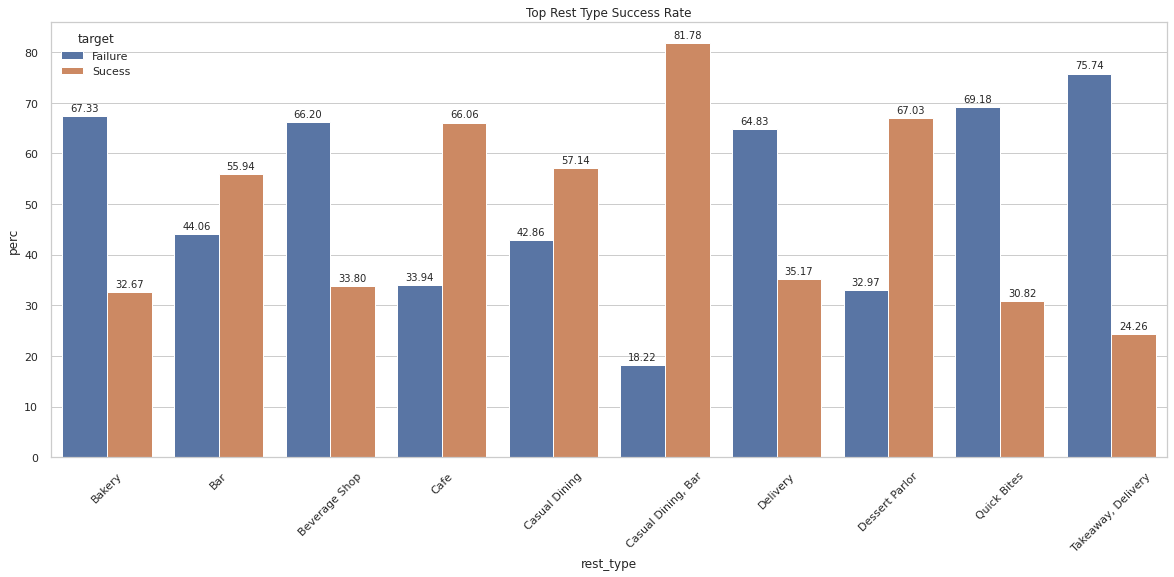

In [78]:
success_rate_type= df[df['rest_type'].isin(top_types.rest_type)]\
        .groupby(['rest_type','target']).size()\
        .reset_index(name="count")
success_rate_type['perc'] = success_rate_type.groupby('rest_type')['count'].apply(lambda x: x*100/x.sum())
plt.figure(figsize = (20,8))
ax2 = sns.barplot(x = 'rest_type',y='perc',hue='target', data=success_rate_type)
for bar in ax2.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    ax2.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.xticks(rotation = 45)
plt.title("Top Rest Type Success Rate")
plt.show()

Some of the restaurants are for casual dining and some are considered bars only. Since Bangalore is a metropoitan area with a high standard of living, the data indicates that casual dining restaurants have a higher chance of success. Restaurants that do not offer dine-in have a higher rate of failure.

##Create a dataframe for Top 10 locations along with each rest type count


In [79]:
rest_type_loc = df[df['location'].isin(top_loc.location)]\
        .groupby(['location','rest_type'])['name'].count()\
        .reset_index(name="count")#['count'].nlargest(3).reset_index()#.sort_values(['location','count'],ascending=False)
#taking top 3 rest type for top 10 locations
rest_type_loc = rest_type_loc.set_index('rest_type').groupby(['location'])['count'].nlargest(3).reset_index()



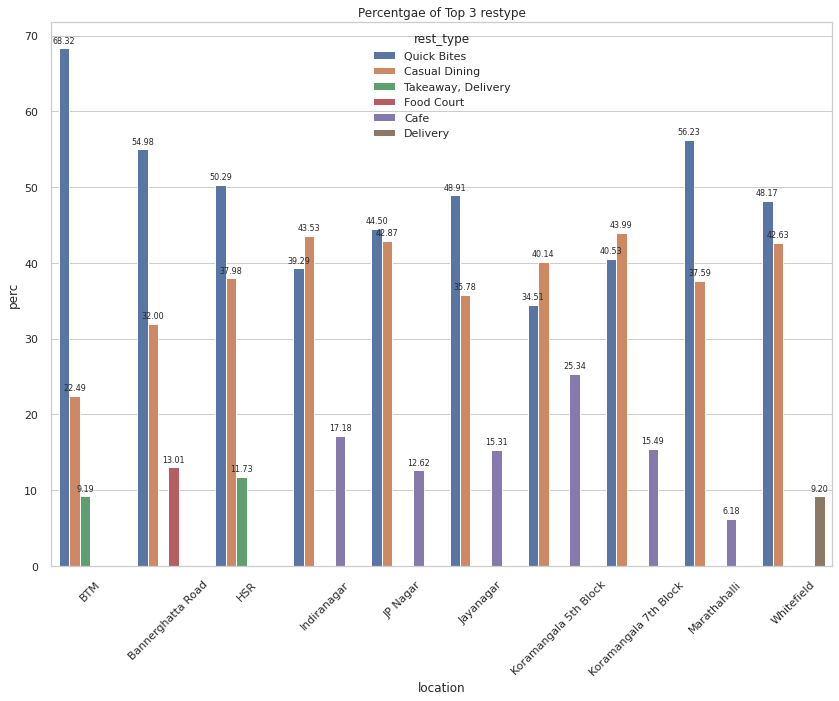

In [80]:
#taking top 3 rest type for top 10 locations
rest_type_loc['perc'] = rest_type_loc.groupby('location')['count'].apply(lambda x: x*100/x.sum())
plt.figure(figsize = (14, 10))
plots = sns.barplot(x = 'location', y = 'perc', data = rest_type_loc, hue = 'rest_type')
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
plt.title("Percentgae of Top 3 restaurant type")
plt.xticks(rotation = 45)
plt.show()


Casual dining restaurants are at the top in all ten locations. Quick bites restaurants are next in number in all top-10 locations.

##Create a dataframe for Top 10 locations along with each cuisine count


In [81]:
cuisine_loc = df[df['location'].isin(top_loc.location)]\
        .groupby(['location','cuisines'])['name'].count()\
        .reset_index(name="count")#['count'].nlargest(3).reset_index()#.sort_values(['location','count'],ascending=False)
#taking top 3 cuisines for top 10 locations
cuisine_loc = cuisine_loc.set_index('cuisines').groupby(['location'])['count'].nlargest(2).reset_index()


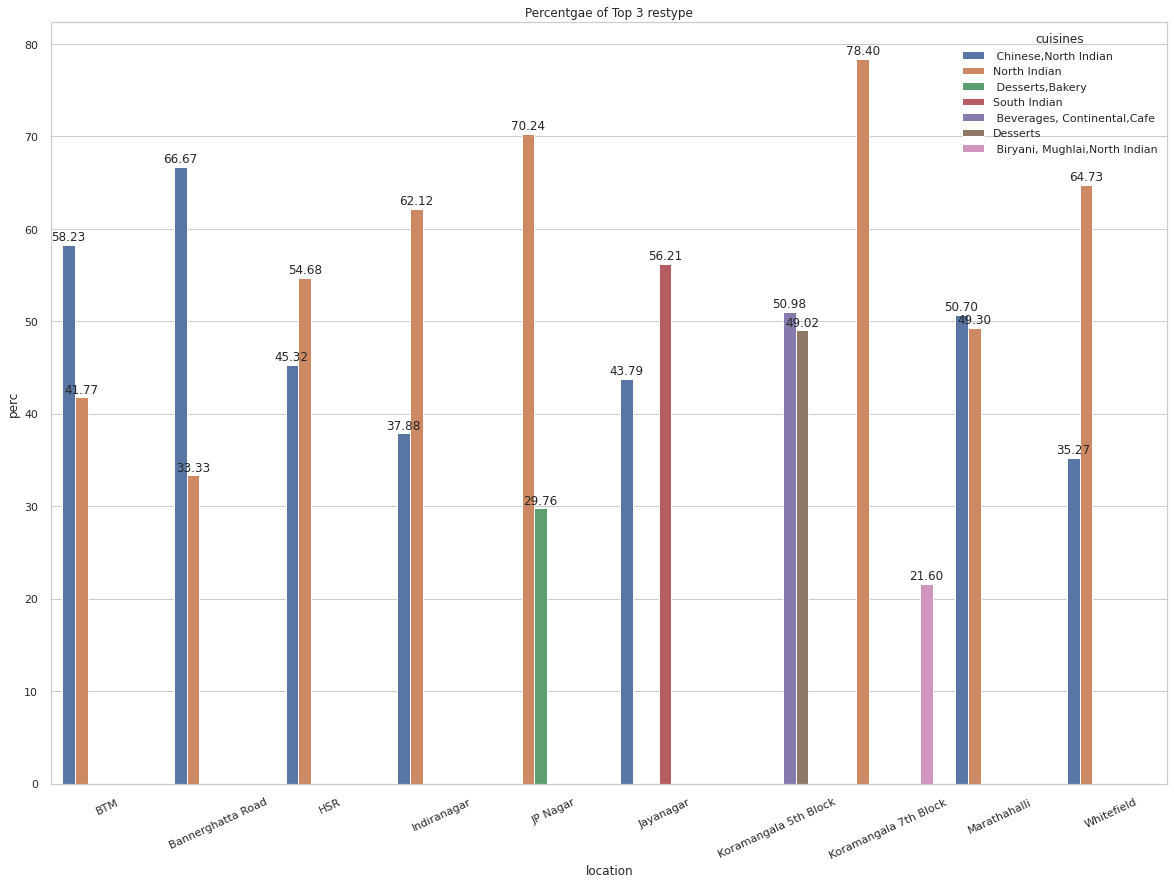

In [82]:
#taking top 3 cuisines for top 10 locations
cuisine_loc['perc'] = cuisine_loc.groupby('location')['count'].apply(lambda x: x*100/x.sum())
plt.figure(figsize = (20, 14))
plots = sns.barplot(x = 'location', y = 'perc', data = cuisine_loc, hue = 'cuisines')
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
plt.title("Percentgae of Top 3 restype")
plt.xticks(rotation = 25)
plt.show()




The most common cuisine is North Indian. The second most common cuisine is chinese. 


##Correlation Matrix

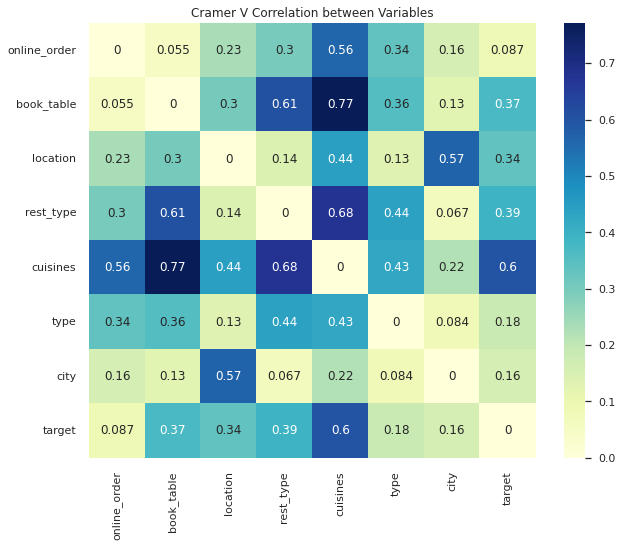

In [83]:
import itertools
import scipy.stats as ss
import itertools
from scipy.stats import norm
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
cols = ['online_order', 'book_table', 
       'location', 'rest_type', 'cuisines', 
       'type', 'city', 'target']
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df[col1], df[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]
corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr, annot=True,ax=ax,cmap="YlGnBu"); ax.set_title("Cramer V Correlation between Variables");


As per Cramer's correlation coefficient our target variable is having medium to high correlation with independent features such as book_table, location, rest_type and low correlation with features such as type and online_order.

Assumptions: We will not use the ‘votes’, ‘reviews’, ‘dishes_liked’ features as the information is available after the restaurant opens. We want make predictions, the idea is to return the probability of success of a restaurant before launching it.

Features :

    online_order
    book_table
    location
    rest_type
    cuisines
    city
    approx_cost

Split Data : We will split the data into train and test data.

Data featurization : We will use one-hot encoding technique for featurization to encode Categorical features such as ‘online_order’, ‘book_table’, ‘location’, ‘rest-type’ and ‘cuisines’. Numerical feature should be standardized to shift the distribution to have a mean of zero and a standard deviation of one. For doing the data featurization we can rely on Sklearn ColumnTransformer.

##Base Line modelling

For Base Line Modelling we will train following models with default parameters and stratified cross validation of 5.

Models:

    Logistic Regression
    RandomForestClassifier
    XGBClassifier
    DecisionTreeClassifier
    LightGBM





In [84]:
RANDOM_SEED = 42
features = ['online_order', 'book_table',
       'location', 'rest_type',  'cuisines',
       'approx_cost(for two people)','city']
df['target_encode'] = np.where(df.target=="Sucess", 1, 0)
X = df[features]
y = df['target_encode']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=RANDOM_SEED)
num_columns_derived = ['approx_cost(for two people)']
cat_columns_derived = ['online_order', 'book_table', 
       'location', 'rest_type',  'cuisines',
       'city']
############################################################################################################################# 
#setting the pipes for the transformation 
categorical_pipe = Pipeline([('get_dummies',OneHotEncoder(handle_unknown='ignore'))])
numeric_pipe = Pipeline([('scaling',StandardScaler())])

# set up columnTransformer
col_transformer_derived = ColumnTransformer(
                    transformers=[
                        ('cat', categorical_pipe, cat_columns_derived), ('num', numeric_pipe, num_columns_derived)
                    ],
                    remainder='passthrough',
                    n_jobs=-1
                    )
##########################################################################################################################
X_train = col_transformer_derived.fit_transform(X_train) 

In [42]:
lgbm = lgb.LGBMClassifier(random_state=RANDOM_SEED)
rf = RandomForestClassifier(random_state=RANDOM_SEED)
lr = LogisticRegression(random_state=RANDOM_SEED)
xgb = XGBClassifier(seed=RANDOM_SEED)
dtree = DecisionTreeClassifier(random_state=RANDOM_SEED)
test_performance = {}
test_performance['model'] = []
test_performance['precision'] = []
test_performance['recall'] = []
test_performance['f1'] = []
test_performance['auc'] = []
test_performance['cv_auc'] = []
models = [lr,rf, xgb, dtree, lgbm]
names = ["Logistic Regresion", "Random Forest","Xgboost","Decision Tree","LightGBM"]
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = RANDOM_SEED)
for model, name in zip(models, names):
    cv_auc = cross_val_score(model, X_train, y_train, cv=skf,scoring='roc_auc')
    model.fit(X_train,y_train)
    y_pred = model.predict(col_transformer_derived.transform(X_test)) 
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    test_performance['model'].append(name)
    test_performance['precision'].append(round(precision, 3))
    test_performance['recall'].append(round(recall, 3))
    test_performance['f1'].append(round(f1, 3))
    test_performance['auc'].append(round(auc, 3))
    test_performance['cv_auc'].append(round(np.array(cv_auc).mean(), 3))


In [85]:
import jinja2
from pycaret.classification import *
#Creating a DataFrame with metrics
performance_metrics = pd.DataFrame(test_performance)#.reset_index(drop=True).loc[:0, :]
performance_metrics.reset_index(drop=True).style.background_gradient(cmap='Blues')

,model,precision,recall,f1,auc,cv_auc
0,Logistic Regresion,0.837000,0.746000,0.789000,0.804000,0.879000
1,Random Forest,0.950000,0.909000,0.929000,0.932000,0.959000
2,Xgboost,0.787000,0.593000,0.676000,0.721000,0.816000
3,Decision Tree,0.951000,0.934000,0.942000,0.944000,0.927000
4,LightGBM,0.832000,0.691000,0.755000,0.780000,0.865000


##Base Line model improving

From above dataframe, Random forest classifier is having best performace metrics among the list of models we trained. Let us try to improve this model by doing some more feature engineering and hyperparametr tuning.

Features Engineered columns:

    total_cuisines : No. of different types of cuisines. This is information can be gotten before the launching of the establishment.
    multi_type_restuarant : Is the restauarant a multi type restaurant, and total no of differnt types.



In [86]:
#Creating two new features
df['total_cuisines'] = df.cuisines.map(lambda x: [i.strip() for i in x.split(",")]).apply(len)
df['multi_type_restuarant'] = df.rest_type.map(lambda x: [i.strip() for i in x.split(",")]).apply(len)
random_state = 42
features = ['online_order', 'book_table',
       'location', 'rest_type',  'cuisines',
       'approx_cost(for two people)','city','total_cuisines','multi_type_restuarant']
X = df[features]
y = df['target_encode']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=random_state)
num_columns_derived = ['approx_cost(for two people)','total_cuisines','multi_type_restuarant']
cat_columns_derived = ['online_order', 'book_table', 
       'location', 'rest_type',  'cuisines',
       'city']
############################################################################################################################# 


#setting the pipes for the transformation 
categorical_pipe = Pipeline([('get_dummies',OneHotEncoder(handle_unknown='ignore'))])
numeric_pipe = Pipeline([('scaling',StandardScaler())])

# set up columnTransformer
col_transformer_derived = ColumnTransformer(
                    transformers=[
                        ('cat', categorical_pipe, cat_columns_derived), ('num', numeric_pipe, num_columns_derived)
                    ],
                    remainder='passthrough',
                    n_jobs=-1
                    )


##########################################################################################################################
X_train = col_transformer_derived.fit_transform(X_train,y_train) 


Bayesian Hyperparameter Optimization(Hyperopt) 

Bayesian optimisation takes past evaluations into account when choosing the hyperparameter set to evaluate next. By choosing its parameter combinations in an informed way, it enables itself to focus on those areas of the parameter space that it believes will bring the most promising validation scores. This approach requires less iterations to get to the optimal set of hyperparameter values. 



In [87]:
#Defining the search space
def rf_space():
    space_dict = {'lane': [],
                  'randomforestclassifer__n_estimators': hp.uniform(
                    'randomforestclassifer_n_estimators', 10, 1000),
                  'randomforest__max_features': hp.choice(
                    'randomforest_max_features', ['auto', 'sqrt'])}
    return space_dict
#Objective function to minimize
def rf_hyp_obective(space):
          
                # Instantiating regressors
                rf_estimator = 'randomforestclassifer__n_estimators'
                rf_max_feature = 'randomforest__max_features'
                fit = RandomForestClassifier(
                      n_estimators=int(space[rf_estimator]),
                      max_features=space[rf_max_feature],
                      n_jobs=-1,
                      random_state=RANDOM_SEED)
                auc = abs(cross_val_score(
                                    fit, X_train, y_train,
                                    scoring='roc_auc',
                                    n_jobs=-1, cv=skf
                      ).mean())
                print("auc :- ", auc)
                return {'loss': -auc, 'status': STATUS_OK}
#Evaluating for 10 trails                
trials = Trials()
rf_space_dict = rf_space()
best_rf_hyp = fmin(fn=rf_hyp_obective,
                   space=rf_space_dict,
                   algo=tpe.suggest,
                   max_evals=10,
                   trials=trials,
                   rstate=np.random.RandomState(RANDOM_SEED),
                   show_progressbar=False)

auc :- 
0.962404794820895
auc :- 
0.9624128672823998
auc :- 
0.9625858563994404
auc :- 
0.9624027256592144
auc :- 
0.9625843831100881
auc :- 
0.9625807493832795
auc :- 
0.9625840876442059
auc :- 
0.9625696811222224
auc :- 
0.9624986414493607
auc :- 
0.9626259838937674


##Fitting the best model

In [88]:
n_estimators = best_rf_hyp['randomforestclassifer_n_estimators']
max_features = 'auto' if(best_rf_hyp["randomforest_max_features"] == 0) else 'sqrt'
best_fit = RandomForestClassifier(
                      n_estimators=int(n_estimators),
                      max_features=max_features,
                      n_jobs=-1,
                      random_state=RANDOM_SEED)
best_fit.fit(X_train,y_train)
best_performance = {}
best_performance['model'] = []
best_performance['precision'] = []
best_performance['recall'] = []
best_performance['f1'] = []
best_performance['auc'] = []
y_pred = best_fit.predict(col_transformer_derived.transform(X_test)) 
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
best_performance['model'].append("Random Forest Tuned")
best_performance['precision'].append(round(precision, 3))
best_performance['recall'].append(round(recall, 3))
best_performance['f1'].append(round(f1, 3))
best_performance['auc'].append(round(auc, 3))


In [89]:
performance_metrics_tuned = pd.DataFrame(best_performance)
performance_metrics = pd.concat([performance_metrics,performance_metrics_tuned],axis=0)
performance_metrics.reset_index(drop=True).style.background_gradient(cmap='Blues')

,model,precision,recall,f1,auc,cv_auc
0,Logistic Regresion,0.837000,0.746000,0.789000,0.804000,0.879000
1,Random Forest,0.950000,0.909000,0.929000,0.932000,0.959000
2,Xgboost,0.787000,0.593000,0.676000,0.721000,0.816000
3,Decision Tree,0.951000,0.934000,0.942000,0.944000,0.927000
4,LightGBM,0.832000,0.691000,0.755000,0.780000,0.865000
5,Random Forest Tuned,0.951000,0.915000,0.932000,0.935000,nan


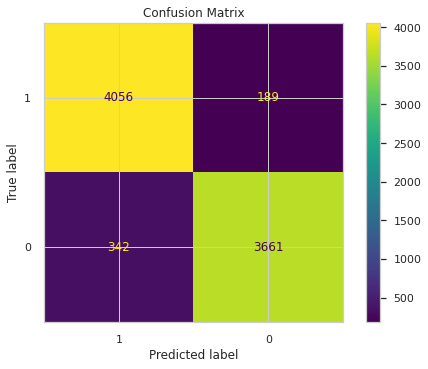

In [90]:
from sklearn.metrics import plot_confusion_matrix
class_names = {1:"Success",0:"Failure"}
disp = plot_confusion_matrix(best_fit, col_transformer_derived.transform(X_test), y_test,display_labels=class_names,)
disp.ax_.set_title("Confusion Matrix")
plt.show()

##Custom Stacking classifier

In [ ]:
# def custom_ensemble(X_train, y_train, X_test, y_test, n_estimators, hyperparams):
#         """
#         This function receives information for n_estimators to be trained, the data to be used on training and other
#         parameters for fitting the model to the data.

#         Parameters
#         ----------
#         :param X_train: object containing features [type: df]
#         :param y_train: object containing target variable [type: df]
#         :param X_test: object containing features for testing the model [type: df]
#         :param y_test: Actual target varaible used testing the model [type: df]
#         :param n_estimators: list of estimators taht should be trained [type: list]
#         :param hyperparams: dictionary containing estimators and hyperparameters inner dict [type: dict]
#         Return
#         ------
#         This method  returns meta classifer prediction
        
#         """
#         X_base,X_meta,y_base,y_meta = train_test_split(X_train,y_train,test_size=.5,random_state=RANDOM_SEED)
        
#         D1 = pd.concat([X_base,y_base],axis=1)
#         D2 = pd.concat([X_meta,y_meta],axis=1)
#         d1 = D1.sample(replace=True,frac =.40)
#         d2 = D1.sample(replace=True,frac =.40)
#         d3 = D1.sample(replace=True,frac =.40)
#         k_samples = [d1,d2,d3]
#         base_learners_prediction = []
#         best_estimators = []
        
        
#         for sample, estimator, param in zip(k_samples,base_learners,list(hyperparams.keys())):
#             X_sample = sample[features]
#             y_sample = sample['target_encode']
#             num_columns_derived = ['approx_cost(for two people)']
#             cat_columns_derived = ['online_order', 'book_table', 
#                    'location', 'rest_type',  'cuisines',
#                    'city']
#             ############################################################################################################################# 


#             #setting the pipes for the transformation 
#             categorical_pipe = Pipeline([('get_dummies',TargetEncoder(handle_unknown='value'))])
#             numeric_pipe = Pipeline([('scaling',StandardScaler())])

#             # set up columnTransformer
#             col_transformer_derived = ColumnTransformer(
#                                 transformers=[
#                                     ('cat', categorical_pipe, cat_columns_derived), ('num', numeric_pipe, num_columns_derived)
#                                 ],
#                                 remainder='passthrough',
#                                 n_jobs=-1
#                                 )


#             ##########################################################################################################################
#             X_sample = col_transformer_derived.fit_transform(X_sample,y_sample) 
#             #base_learner.fit(X_sample,y_sample)
#             print(estimator)
#             print(hyperparams[param])
#             model = RandomizedSearchCV(estimator, hyperparams[param], cv = 3)
#             model.fit(X_sample, y_sample)
#             best_estimators.append(model.best_estimator_)
#             y_pred = model.predict(col_transformer_derived.transform(X_meta)).tolist()
#             base_learners_prediction.append(y_pred)
#         base_learners_prediction = pd.DataFrame(base_learners_prediction,index =['RF', 'LR', 'DT']).T
#         base_learners_prediction['True_Label'] = D2['target_encode'].tolist()

#     # Metaclassifier training and prediction

#         meta_classifier = lgb.LGBMClassifier(seed=RANDOM_SEED).fit(base_learners_prediction.drop(['True_Label'],axis=1),base_learners_prediction['True_Label'])
#         base_learners_prediction_test_set = []
#         for sample, base_learner in zip(X_test,best_estimators):
#             X_base_test = X_test[features]
#             y_pred = base_learner.predict(col_transformer_derived.transform(X_test)).tolist()
#             base_learners_prediction_test_set.append(y_pred)
#         base_learners_prediction_test_set = pd.DataFrame(base_learners_prediction_test_set,index =['RF', 'LR', 'DT']).T
#         base_learners_prediction_test_set['True_Label'] = y_test.tolist()
#         y_pred = meta_classifier.predict(base_learners_prediction_test_set[['RF', 'LR', 'DT']])

        
#         return y_pred


In [91]:
def custom_ensemble(X_train, y_train, X_test, y_test, n_estimators):
        """
        This function receives information for n_estimators to be trained, the data to be used on training and other
        parameters for fitting the model to the data.
        """
        X_base,X_meta,y_base,y_meta = train_test_split(X_train,y_train,test_size=.5,random_state=RANDOM_SEED)
        
        D1 = pd.concat([X_base,y_base],axis=1)
        D2 = pd.concat([X_meta,y_meta],axis=1)
#         d1 = D1.sample(replace=True,frac =.40)
#         d2 = D1.sample(replace=True,frac =.40)
#         d3 = D1.sample(replace=True,frac =.40)
#         k_samples = [d1,d2,d3]
        base_learners_prediction = []
        listofAllModels = []
        
        
        for estimator in  (range(n_estimators)):
            sample = D1.sample(replace=True,frac =.40)
            X_sample = sample[features]
            y_sample = sample['target_encode']
            num_columns_derived = ['approx_cost(for two people)']
            cat_columns_derived = ['online_order', 'book_table', 
                   'location', 'rest_type',  'cuisines',
                   'city']
            ############################################################################################################################# 


            #setting the pipes for the transformation 
            categorical_pipe = Pipeline([('get_dummies',TargetEncoder(handle_unknown='value'))])
            numeric_pipe = Pipeline([('scaling',StandardScaler())])

            # set up columnTransformer
            col_transformer_derived = ColumnTransformer(
                                transformers=[
                                    ('cat', categorical_pipe, cat_columns_derived), ('num', numeric_pipe, num_columns_derived)
                                ],
                                remainder='passthrough',
                                n_jobs=-1
                                )


            ##########################################################################################################################
            X_sample = col_transformer_derived.fit_transform(X_sample,y_sample) 
            model = RandomForestClassifier(random_state=RANDOM_SEED)
            model.fit(X_sample, y_sample)
            listofAllModels.append(model)
            y_pred = model.predict(col_transformer_derived.transform(X_meta)).tolist()
            base_learners_prediction.append(y_pred)
        base_learners_prediction = pd.DataFrame(base_learners_prediction).T
        base_learners_prediction['True_Label'] = D2['target_encode'].tolist()

    # Metaclassifier training and prediction

        meta_classifier = lgb.LGBMClassifier(seed=RANDOM_SEED).fit(base_learners_prediction.drop(['True_Label'],axis=1),base_learners_prediction['True_Label'])
        base_learners_prediction_test_set = []
        for sample, base_learner in zip(X_test,listofAllModels):
            X_base_test = X_test[features]
            y_pred = base_learner.predict(col_transformer_derived.transform(X_test)).tolist()
            base_learners_prediction_test_set.append(y_pred)
        base_learners_prediction_test_set = pd.DataFrame(base_learners_prediction_test_set).T
        base_learners_prediction_test_set['True_Label'] = y_test.tolist()
        y_pred = meta_classifier.predict(base_learners_prediction_test_set.drop(['True_Label'],axis=1))

        
        return y_pred, meta_classifier,base_learners_prediction_test_set


In [92]:
# def CreateAlistofAllModels(list_input_data, list_output_data, n_estimator):
#     listofAllModels = []
#     for i in tqdm(range(n_estimator)):
#         model = DecisionTreeRegressor()
#         model.fit(list_input_data[i], list_output_data[i])
#         listofAllModels.append(model)
#     gc.collect()
#     return listofAllModels


In [ ]:
RANDOM_SEED = 42
features = ['online_order', 'book_table',
       'location', 'rest_type',  'cuisines',
       'approx_cost(for two people)','city']
df['target_encode'] = np.where(df.target=="Sucess", 1, 0)
X = df[features]
y = df['target_encode']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=RANDOM_SEED)

#Define the estimators and corresponding search space
estimators = [RandomForestClassifier(random_state=RANDOM_SEED),
                         LogisticRegression(random_state=RANDOM_SEED)]
# hyperparams = {
    
#        "rf": {
#          'max_features': ['auto', 'sqrt'],
#          'min_samples_split': [5, 10, 15],
#          'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 600, num = 10)]},
    
#      "lr":{'C': np.logspace(-1, 8, 10)},
    
#     "dt" : {
#               "max_features": randint(1, 9),
#               "min_samples_leaf": randint(1, 9),
#               "criterion": ["gini", "entropy"]}

#                 }

y_pred,meta_classifier,base_learners_prediction_test_set = custom_ensemble(X_train,y_train,X_test, y_test,3)

In [93]:
meta_performance = {}
meta_performance['model'] = []
meta_performance['precision'] = []
meta_performance['recall'] = []
meta_performance['f1'] = []
meta_performance['auc'] = []
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
meta_performance['model'].append("Meta Classifier-LGBM")
meta_performance['precision'].append(round(precision, 3))
meta_performance['recall'].append(round(recall, 3))
meta_performance['f1'].append(round(f1, 3))
meta_performance['auc'].append(round(auc, 3))

In [ ]:
performance_metrics_custom = pd.DataFrame(meta_performance)
performance_metrics = pd.concat([performance_metrics,performance_metrics_custom],axis=0)
performance_metrics.reset_index(drop=True).style.background_gradient(cmap='Blues')

In [ ]:
from sklearn.metrics import plot_confusion_matrix
class_names = {1:"Success",0:"Failure"}
disp = plot_confusion_matrix(meta_classifier, base_learners_prediction_test_set.drop(['True_Label'],axis=1), y_test,display_labels=class_names,)
disp.ax_.set_title("Confusion Matrix")
plt.show()

##Feature importance

The base learner in this study is Random Forest, we show the 5 most important features and the best one to predict success of a restaurant is book_table.

##Final Models

In [94]:
performance_metrics.reset_index(drop=True).style.background_gradient(cmap='Blues')#.reset_index()
#5 th Random forest is hyper parameter tuned with additional features engineered

,model,precision,recall,f1,auc,cv_auc
0,Logistic Regresion,0.837000,0.746000,0.789000,0.804000,0.879000
1,Random Forest,0.950000,0.909000,0.929000,0.932000,0.959000
2,Xgboost,0.787000,0.593000,0.676000,0.721000,0.816000
3,Decision Tree,0.951000,0.934000,0.942000,0.944000,0.927000
4,LightGBM,0.832000,0.691000,0.755000,0.780000,0.865000
5,Random Forest Tuned,0.951000,0.915000,0.932000,0.935000,nan


In [95]:
import joblib
joblib.dump(value=best_fit, filename='model.pkl')
joblib.dump(value=col_transformer_derived, filename='pipeline.pkl')

['pipeline.pkl']

##Productionalizing final function

In [96]:
def final_model(X):
#preprocess data i.e data cleaning, filling missing values etc
    test = pd.DataFrame(X)
    #compute features based on this X
    test['total_cuisines'] = test.cuisines.map(lambda x: [i.strip() for i in str(x).split(",")]).apply(len)
    test['multi_type_restuarant'] = test.rest_type.map(lambda x: [i.strip() for i in str(x).split(",")]).apply(len)
    #use pre trained model
    model = joblib.load('model.pkl')
    pipeline = joblib.load('pipeline.pkl')
    y_pred = model.predict(pipeline.transform(test)) 
    y_pred_corrected = np.where(y_pred==1,"Success","Failure")
    return y_pred_corrected

In [97]:
test = [{"online_order":"No","book_table":"Yes","location":"HSR","rest_type":"Fine Dining"\
      ,"cuisines":"Asian,European","approx_cost(for two people)":800,"city":"BTM"}]
final_model(test)


array(['Success'], dtype='<U7')